This nb is used in order to visualize and interpret the decision that our nn makes when predicting the class of an image. It uses the integrated gradients method and visualize the results. 

In [1]:
#imports:

import torch
import torch.nn as nn
import torch.nn.functional as F

from PIL import Image

import os
import json
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

import timm
from torchvision import transforms

from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

In [2]:
# creating the class for the model:

class resnet50(nn.Module):

    def __init__(self):
        super(resnet50, self).__init__()
        self.model = timm.create_model('resnet50', pretrained=False)
        self.model.classification = nn.Linear(self.model.fc.out_features, 1)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        x = self.model(x)
        x = self.dropout(x)
        x = self.model.classification(x)
        x = self.sigmoid(x)
        return x

In [3]:
# loading the model:

model = resnet50()

# load weights:

model.load_state_dict(torch.load('/home/dogoulis/WORKSPACE/gan-prediction/checkpoints/epoch-0.pt'))

<All keys matched successfully>

In [4]:
# define transforms

transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor()
])

In [5]:
img_dir = '/home/dogoulis/WORKSPACE/data/FFHQ/49253.png'

img = Image.open(img_dir)

transformed_img = transform(img)

# change the dimensions in order to fit in the model:

img_ = transformed_img.unsqueeze(0)

# pass the image to the model:

output = model(img_)

/home/dogoulis/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [6]:
# defining interpretability method:

integrated_gradients = IntegratedGradients(model)

attributions_ig = integrated_gradients.attribute(img_, n_steps=200)

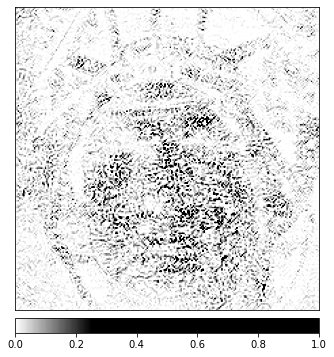

In [7]:
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)